# Note: python version used = 3.11.9

In [79]:
!pip install faker numpy pandas

# Part 1: Creation of data

## Import the Libraries 

In [80]:
import numpy as np
import pandas as pd
import faker # main
import random

In [81]:
fake = faker.Faker()
N_rows = 1000
output_file = "sinthetic_bodyfat_data.csv"

## Functions

In [82]:
def calculate_bmi (weight,height_cm):
    height_m = height_cm/100
    return weight/height_m

def generate_bodyfat_data (gender, bmi, waist, neck_cm):
    if gender == 1: # Male
        bf = (
            0.25 * bmi + 0.35 * (waist / 100) * 100 - 0.20 * (neck_cm / 100) + np.random.normal(0, 1.5)
        )
        return np.clip(bf,8,35)
    else : # Female
        bf = (
            0.30 * bmi + 0.40 * (waist / 100) * 100 - 0.15 * (neck_cm / 100) * 100 + np.random.normal(0, 2.0)
            )
        return np.clip(bf, 18, 45)

## Data Generation

In [83]:
for i in range(N_rows):
    age = random.randint(18, 40)
    gender = random.choice([0, 1]) # 0 = Female, 1 = Male
    if gender == 1:
        height_cm = random.randint(160, 185)
        neck_cm = random.uniform(34, 42)
    else:
        height_cm = random.randint(150, 175)
        neck_cm = random.uniform(30, 38)
    bmi = random.uniform(18, 32)
    weight_kg = bmi * (height_cm / 100) ** 2
    weight_kg += random.uniform(-2, 2)
    waist_cm = random.uniform(0.45, 0.60) * height_cm
    waist_cm += random.uniform(-2, 2)
    body_fat = generate_bodyfat_data(
        gender,
        calculate_bmi(weight_kg, height_cm),
        waist_cm,
        neck_cm
        )
    data.append([
        age,
        gender,
        round(height_cm, 1),
        round(weight_kg, 1),
        round(waist_cm, 1),
        round(neck_cm, 1),
        round(body_fat, 1)
        ])

## Create DataFrame & Export

In [84]:
columns = [
"age",
"gender",
"height_cm",
"weight_kg",
"waist_cm",
"neck_cm",
"body_fat_percent"
]


df = pd.DataFrame(data, columns=columns)
df.to_csv(output_file, index=False)


print(f" Synthetic dataset generated: {output_file}")
print(df.head())


 Synthetic dataset generated: sinthetic_bodyfat_data.csv
   age  gender  height_cm  weight_kg  waist_cm  neck_cm  body_fat_percent
0   22       1        172       61.3      87.1     36.3              35.0
1   22       0        162       69.2      89.5     32.9              45.0
2   33       0        174       93.2      97.4     33.0              45.0
3   34       1        166       55.9      95.4     40.1              35.0
4   36       1        180       80.9      89.7     38.9              35.0


In [85]:
print(df.tail())

      age  gender  height_cm  weight_kg  waist_cm  neck_cm  body_fat_percent
5996   30       0        152       48.6      90.9     34.7              39.0
5997   23       0        168       51.3      80.2     34.6              32.0
5998   19       1        165       50.1      75.4     38.1              35.0
5999   24       1        160       75.3      94.0     36.1              35.0
6000   38       0        165       55.4      90.9     37.4              38.0


# Part 2: EDA

In [86]:
import pandas as pd
df = pd.read_csv("sinthetic_bodyfat_data.csv")
df.head()
df.shape
df.info()
df.describe()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6001 entries, 0 to 6000
Data columns (total 7 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   age               6001 non-null   int64  
 1   gender            6001 non-null   int64  
 2   height_cm         6001 non-null   int64  
 3   weight_kg         6001 non-null   float64
 4   waist_cm          6001 non-null   float64
 5   neck_cm           6001 non-null   float64
 6   body_fat_percent  6001 non-null   float64
dtypes: float64(4), int64(3)
memory usage: 328.3 KB


,age,gender,height_cm,weight_kg,waist_cm,neck_cm,body_fat_percent
count,6001.000000,6001.00000,6001.000000,6001.000000,6001.000000,6001.000000,6001.000000
mean,28.830695,0.50125,167.541743,70.077170,87.983936,36.016881,37.809648
std,6.603257,0.50004,9.008402,13.773092,8.747109,3.046627,3.916592
min,18.000000,0.00000,150.000000,39.700000,67.100000,30.000000,27.400000
25%,23.000000,0.00000,161.000000,59.200000,81.400000,34.000000,35.000000
50%,29.000000,1.00000,168.000000,69.200000,87.700000,36.100000,35.000000
75%,34.000000,1.00000,174.000000,80.000000,94.300000,38.100000,41.100000
max,40.000000,1.00000,185.000000,110.500000,112.200000,42.000000,45.000000


## Graph plotting

In [87]:
!pip install matplotlib

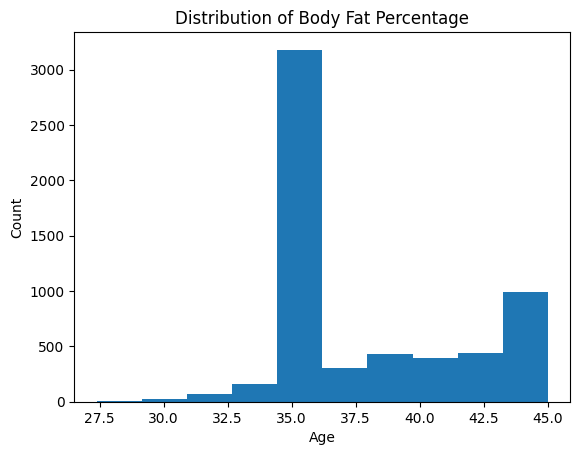

In [88]:
import matplotlib.pyplot as plt

plt.hist(df["body_fat_percent"])
plt.xlabel("Age")
plt.ylabel("Count")
plt.title("Distribution of Body Fat Percentage")
plt.show()

## Gender wise body fat comparision

In [89]:
df.groupby('gender')["body_fat_percent"].describe()

,count,mean,std,min,25%,50%,75%,max
gender,,,,,,,,
0,2993.0,40.668694,3.791275,27.4,38.0,41.1,44.5,45.0
1,3008.0,34.964860,0.272590,29.8,35.0,35.0,35.0,35.0


In [90]:
corr = df.corr(numeric_only=True)
corr["body_fat_percent"].sort_values()

gender             -0.728221
neck_cm            -0.514695
height_cm          -0.215530
age                 0.024987
weight_kg           0.057570
waist_cm            0.123529
body_fat_percent    1.000000
Name: body_fat_percent, dtype: float64

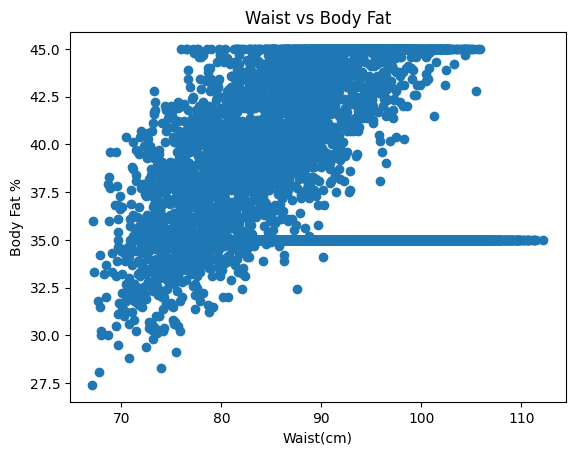

In [92]:
plt.scatter(df["waist_cm"],df["body_fat_percent"])
plt.xlabel('Waist(cm)')
plt.ylabel('Body Fat %')
plt.title("Waist vs Body Fat")
plt.show()

## outlier

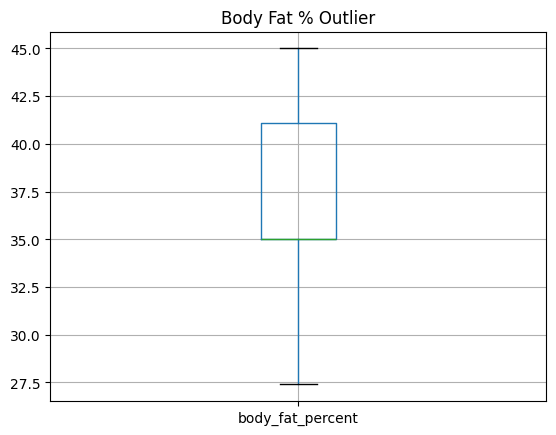

In [93]:
df.boxplot(column="body_fat_percent")
plt.title("Body Fat % Outlier")
plt.show()

In [94]:
assert (df["waist_cm"] < df["height_cm"]).all()
assert (df["neck_cm"] < df["waist_cm"]).all()
assert (df["body_fat_percent"] > 0).all()

# Modelling

In [95]:
import pandas as pd

df=pd.read_csv("sinthetic_bodyfat_data.csv")

In [97]:
x = df[["age","gender","height_cm","weight_kg","waist_cm","neck_cm"]]
y = df["body_fat_percent"]

In [99]:
from sklearn.model_selection import train_test_split

x_train, x_test, y_train, y_test = train_test_split(x,y,test_size=0.2,random_state=42)

In [104]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()

x_train_scaled = scaler.fit_transform(x_train)
x_test_scaled = scaler.transform(x_test)

In [107]:
from sklearn.linear_model import LinearRegression

model = LinearRegression()
model.fit(x_train_scaled,y_train)

,"fit_intercept fit_intercept: bool, default=TrueWhether to calculate the intercept for this model. If setto False, no intercept will be used in calculations(i.e. data is expected to be centered).",True
,"copy_X copy_X: bool, default=TrueIf True, X will be copied; else, it may be overwritten.",True
,"tol tol: float, default=1e-6The precision of the solution (`coef_`) is determined by `tol` whichspecifies a different convergence criterion for the `lsqr` solver.`tol` is set as `atol` and `btol` of :func:`scipy.sparse.linalg.lsqr` whenfitting on sparse training data. This parameter has no effect when fittingon dense data... versionadded:: 1.7",1e-06
,"n_jobs n_jobs: int, default=NoneThe number of jobs to use for the computation. This will only providespeedup in case of sufficiently large problems, that is if firstly`n_targets > 1` and secondly `X` is sparse or if `positive` is setto `True`. ``None`` means 1 unless in a:obj:`joblib.parallel_backend` context. ``-1`` means using allprocessors. See :term:`Glossary ` for more details.",None
,"positive positive: bool, default=FalseWhen set to ``True``, forces the coefficients to be positive. Thisoption is only supported for dense arrays.For a comparison between a linear regression model with positive constraintson the regression coefficients and a linear regression without such constraints,see :ref:`sphx_glr_auto_examples_linear_model_plot_nnls.py`... versionadded:: 0.24",False


### make prediction

In [119]:
y_pred = model.predict(x_test_scaled)

In [120]:
from sklearn.metrics import mean_absolute_error,mean_squared_error,r2_score

import numpy as np

mae = mean_absolute_error(y_test, y_pred)
rmse = np.sqrt(mean_squared_error(y_test,y_pred))
r2 = r2_score(y_test,y_pred)

print("MAE:", round(mae, 2))
print("RMSE:",round(rmse, 2))
print("R2:", round(r2, 3))

MAE: 1.69
RMSE: 2.13
R2: 0.701


### Inspect Feature Importance

In [127]:
coefficients =pd.DataFrame({"Feature":x.columns,
                            "Coefficient": model.coef_})

print(coefficients.sort_values(by="Coefficient",ascending=False))

     Feature  Coefficient
4   waist_cm     1.315024
3  weight_kg     0.896750
0        age     0.045132
2  height_cm    -0.131241
5    neck_cm    -0.213089
1     gender    -3.293272
